The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


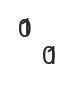

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [11]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


In [12]:
summary_dfs_all = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')
summary_dfs_top10 = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')

# AddPep tests

In [ ]:
addpep_dataset = CDR3BetaDataset(df, max_len=23, cdr3b_col='TRB_CDR3', add_pep=True, 

In [20]:
from src.models import PairedFVAE
model = PairedFVAE()

True

# Meta analysis
Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

--> Take fold that is stable, compare test and train latent for GILGFVCTL (pos and true negs)

In [14]:
x = torch.rand([100,2]).to('cpu')

In [16]:
from torch import cuda